# Extra AST Analyses

This notebooks has extra analyses related to asts. These analyses did not make into the paper.

In [1]:
import sys
sys.path.insert(0, '../archaeology')

from collections import Counter
from pprint import pprint

import matplotlib
import seaborn as sns
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib_venn import venn2, venn3

from db import connect, Query
import analysis_helpers, astutils, importlib
importlib.reload(analysis_helpers)
importlib.reload(astutils)
from analysis_helpers import counter_hist, count
from astutils import chain_hist, show_scope, describe_sets

%matplotlib inline

## Query

Select notebook_asts from:
- valid
  
  ```NOT (n.kernel = 'no-kernel' AND n.nbformat = '0')
  AND n.processed & 15 = 0 AND n.skip & (1024 + 512) = 0```


- non-duplicated
  
  ```n.skip & (1024 + 512 + 128) = 0```


- python notebooks
  
  ```n.language = 'python'```


- with valid syntax
  
  ```n.processed & 16 = 0
  AND LEFT(n.language_version, 1) IN ('2', '3')```

In [2]:
%%time

with connect() as session:
    print('Last query:', session.query(Query).all()[-1])
    asts = pd.read_sql("""
        SELECT a.*
        FROM notebooks n, notebook_asts a
        WHERE NOT (n.kernel = 'no-kernel' AND n.nbformat = '0')
        AND n.processed & 15 = 0
        AND n.skip & 2048 = 0
        AND n.skip & (1024 + 512) = 0
        AND n.skip & (1024 + 512 + 128) = 0
        AND n.language = 'python'
        AND n.processed & 16 = 0
        AND LEFT(n.language_version, 1) IN ('2', '3')
        AND a.notebook_id = n.id
    """, session.connection())
    print("Valid Python notebooks:", len(asts))


Last query: <Query(language:"Jupyter Notebook" created:2018-04-16T03:56:05Z..2018-04-16T22:18:58Z)>
Valid Python notebooks: 886668
CPU times: user 38.3 s, sys: 10.6 s, total: 48.8 s
Wall time: 42.1 s


In [3]:
asts["main_importfrom"] = (
    asts["total_importfrom"]
    - asts["local_importfrom"]
    - asts["nonlocal_importfrom"]
    - asts["global_importfrom"]
    - asts["class_importfrom"]
)

asts["main_import"] = (
    asts["total_import"]
    - asts["local_import"]
    - asts["nonlocal_import"]
    - asts["global_import"]
    - asts["class_import"]
)

asts["main_assign"] = (
    asts["total_assign"]
    - asts["local_assign"]
    - asts["nonlocal_assign"]
    - asts["global_assign"]
    - asts["class_assign"]
)

asts["main_delete"] = (
    asts["total_delete"]
    - asts["local_delete"]
    - asts["nonlocal_delete"]
    - asts["global_delete"]
    - asts["class_delete"]
)

asts["main_functiondef"] = (
    asts["total_functiondef"]
    - asts["local_functiondef"]
    - asts["nonlocal_functiondef"]
    - asts["global_functiondef"]
    - asts["class_functiondef"]
)


asts["main_classdef"] = (
    asts["total_classdef"]
    - asts["local_classdef"]
    - asts["nonlocal_classdef"]
    - asts["global_classdef"]
    - asts["class_classdef"]
)


Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


In [4]:
notebooks = asts
total_notebooks = len(notebooks)

## Alternative Histogram

The notebook A4.RQ3.RQ4 has the proper histogram used in the paper

### Variable

In [5]:
variable_histogram = [
    ("Variable", "Main", len(notebooks[
        (notebooks["total_assign"] != 0)
        | (notebooks["ast_assign"] != 0)
        | (notebooks["assignname"] != 0)
        | (notebooks["assignattr"] != 0)
        | (notebooks["assignitem"] != 0)
        | (notebooks["ast_augassign"] != 0)
        | (notebooks["ast_annassign"] != 0)
        | (notebooks["ast_delete"] != 0)
        | (notebooks["delname"] != 0)
        | (notebooks["delattr"] != 0)
        | (notebooks["delitem"] != 0)
        | (notebooks["ast_global"] != 0)
        | (notebooks["ast_nonlocal"] != 0)
        | (notebooks["ast_name"] != 0)
        | (notebooks["total_delete"] != 0) 
    ])),
    ("Name", ">Variable", len(notebooks[
        (notebooks["ast_name"] != 0)
    ])),
    ("Global Keyword", ">Variable", len(notebooks[
        (notebooks["ast_global"] != 0)
    ])),
    ("NonLocal Keyword", ">Variable", len(notebooks[
        (notebooks["ast_nonlocal"] != 0)
    ])),
    ("Assign", ">Variable", len(notebooks[
        (notebooks["ast_assign"] != 0)
        | (notebooks["assignname"] != 0)
        | (notebooks["assignattr"] != 0)
        | (notebooks["assignitem"] != 0)
    ])),
    ("AugAssign", ">Variable", len(notebooks[
        (notebooks["ast_augassign"] != 0)
    ])),
    ("AnnAssign", ">Variable", len(notebooks[
        (notebooks["ast_annassign"] != 0)
    ])),
    ("Delete", ">Variable", len(notebooks[
        (notebooks["ast_delete"] != 0)
        | (notebooks["delname"] != 0)
        | (notebooks["delattr"] != 0)
        | (notebooks["delitem"] != 0)
    ])),
#    ("GlobalDelete", ">Variable", len(notebooks[
#        (notebooks["global_delete"] != 0)
#    ])),
#    ("NonLocalDelete", ">Variable", len(notebooks[
#        (notebooks["nonlocal_delete"] != 0)
#    ])),
#    ("LocalDelete", ">Variable", len(notebooks[
#        (notebooks["local_delete"] != 0)
#    ])),
]
pprint(variable_histogram)

[('Variable', 'Main', 850069),
 ('Name', '>Variable', 850069),
 ('Global Keyword', '>Variable', 15419),
 ('NonLocal Keyword', '>Variable', 432),
 ('Assign', '>Variable', 839595),
 ('AugAssign', '>Variable', 224613),
 ('AnnAssign', '>Variable', 223),
 ('Delete', '>Variable', 38872)]


### Definition

In [6]:
definitions_histogram = [
    ("Definitions", "Main", len(notebooks[
        (notebooks["ast_functiondef"] != 0)
        | (notebooks["ast_asyncfunctiondef"] != 0)
        | (notebooks["ast_classdef"] != 0)
        | (notebooks["ast_lambda"] != 0)
#       | (notebooks["ast_keyword"] != 0)
    ])),
    ("Functions", ">Definitions", len(notebooks[
        (notebooks["ast_functiondef"] != 0)
    ])),
    ("Returns", ">>Functions", len(notebooks[
        (notebooks["ast_return"] != 0)
    ])),
    ("Generators", ">>Functions", len(notebooks[
        (notebooks["ast_yield"] != 0)
        | (notebooks["ast_yieldfrom"] != 0)
    ])),
    ("Decorators", ">>Functions", len(notebooks[
        (notebooks["functions_with_decorators"] != 0)
    ])),
    ("Lambda", ">Definitions", len(notebooks[
        (notebooks["ast_lambda"] != 0)
    ])),
    ("Async", ">Definitions", len(notebooks[
        (notebooks["ast_await"] != 0)
        | (notebooks["ast_asyncfunctiondef"] != 0)
    ])),
    ("Classes", ">Definitions", len(notebooks[
        (notebooks["total_classdef"] != 0)
    ])),
    ("Decorators", ">>Classes", len(notebooks[
        (notebooks["classes_with_decorators"] != 0)
    ])),
    ("Bases", ">>Classes", len(notebooks[
        (notebooks["classes_with_bases"] != 0)
    ])),

#    ("Keywords", ">>Functions", len(notebooks[
#        (notebooks["ast_keyword"] != 0)
#    ])),


]
pprint(definitions_histogram)

[('Definitions', 'Main', 517768),
 ('Functions', '>Definitions', 481285),
 ('Returns', '>>Functions', 432017),
 ('Generators', '>>Functions', 17778),
 ('Decorators', '>>Functions', 12544),
 ('Lambda', '>Definitions', 156171),
 ('Async', '>Definitions', 199),
 ('Classes', '>Definitions', 75809),
 ('Decorators', '>>Classes', 447),
 ('Bases', '>>Classes', 31459)]


### Import

In [7]:
import_histogram = [
    ("Import", "Main", len(notebooks[
        (notebooks["ast_import"] != 0)
        | (notebooks["ast_importfrom"] != 0)
    ])),
    ("import", ">Import", len(notebooks[
        (notebooks["ast_import"] != 0)
    ])),
    ("importfrom", ">Import", len(notebooks[
        (notebooks["ast_importfrom"] != 0)   
    ])),
]
pprint(import_histogram)

[('Import', 'Main', 808896),
 ('import', '>Import', 774115),
 ('importfrom', '>Import', 607284)]


### Collection

In [8]:
collections_histogram = [
    ("Collection", "Main", len(notebooks[
        (notebooks["ast_list"] != 0)
        | (notebooks["ast_dict"] != 0)
        | (notebooks["ast_set"] != 0)
        | (notebooks["ast_tuple"] != 0)
        | (notebooks["ast_listcomp"] != 0)
        | (notebooks["ast_setcomp"] != 0)
        | (notebooks["ast_dictcomp"] != 0)
        | (notebooks["ast_generatorexp"] != 0)
        | (notebooks["ast_attribute"] != 0)
        | (notebooks["ast_subscript"] != 0)
        | (notebooks["ast_starred"] != 0)
    ])),
    ("List", ">Collections", len(notebooks[
        (notebooks["ast_list"] != 0)
    ])),
    ("Tuple", ">Collections", len(notebooks[
        (notebooks["ast_tuple"] != 0)
    ])),
    ("Dict", ">Collections", len(notebooks[
        (notebooks["ast_dict"] != 0)
    ])),
    ("Set", ">Collections", len(notebooks[
        (notebooks["ast_set"] != 0)
    ])),
    ("ListComp", ">Collections", len(notebooks[
        (notebooks["ast_listcomp"] != 0)
    ])),
    ("GenExpr", ">Collections", len(notebooks[
        (notebooks["ast_generatorexp"] != 0)
    ])),
    ("DictComp", ">Collections", len(notebooks[
        (notebooks["ast_dictcomp"] != 0)
    ])),
    ("SetComp", ">Collections", len(notebooks[
        (notebooks["ast_setcomp"] != 0)
    ])),
    ("Attribute", ">Collections", len(notebooks[
        (notebooks["ast_attribute"] != 0)
    ])),
    ("Subscript", ">Collections", len(notebooks[
        (notebooks["ast_subscript"] != 0)
    ])),
    ("Starred", ">Collections", len(notebooks[
        (notebooks["ast_starred"] != 0)
    ])),
]
pprint(collections_histogram)

[('Collection', 'Main', 837726),
 ('List', '>Collections', 686013),
 ('Tuple', '>Collections', 631587),
 ('Dict', '>Collections', 339882),
 ('Set', '>Collections', 7634),
 ('ListComp', '>Collections', 254373),
 ('GenExpr', '>Collections', 35753),
 ('DictComp', '>Collections', 30465),
 ('SetComp', '>Collections', 2275),
 ('Attribute', '>Collections', 826054),
 ('Subscript', '>Collections', 719990),
 ('Starred', '>Collections', 36246)]


### Control Flow

In [9]:
controlflow_histogram = [
    ("ControlFlow", "Main", len(notebooks[
        (notebooks["ast_for"] != 0)
        | (notebooks["ast_asyncfor"] != 0)
        | (notebooks["ast_while"] != 0)
        | (notebooks["ast_break"] != 0)
        | (notebooks["ast_continue"] != 0)
        | (notebooks["ast_ifexp"] != 0)
        | (notebooks["ast_if"] != 0)
        | (notebooks["ast_pass"] != 0)
        | (notebooks["ast_assert"] != 0)
        | (notebooks["ast_raise"] != 0)
        | (notebooks["ast_tryexcept"] != 0)
        | (notebooks["ast_tryfinally"] != 0)
        | (notebooks["ast_try"] != 0)
        | (notebooks["ast_with"] != 0)
        | (notebooks["ast_asyncwith"] != 0)
    ])),
    ("Loop", ">ControlFlow", len(notebooks[
        (notebooks["ast_for"] != 0)
        | (notebooks["ast_asyncfor"] != 0)
        | (notebooks["ast_while"] != 0)
        | (notebooks["ast_break"] != 0)
        | (notebooks["ast_continue"] != 0)
    ])),
    ("For", ">>Loop", len(notebooks[
        (notebooks["ast_for"] != 0)
        | (notebooks["ast_asyncfor"] != 0)
    ])),
    ("While", ">>Loop", len(notebooks[
        (notebooks["ast_while"] != 0)
    ])),
    ("Break", ">>Loop", len(notebooks[
        (notebooks["ast_break"] != 0)
    ])),
    ("Continue", ">>Loop", len(notebooks[
        (notebooks["ast_continue"] != 0)
    ])),
    ("Condition", ">ControlFlow", len(notebooks[
        (notebooks["ast_ifexp"] != 0)
        | (notebooks["ast_if"] != 0)
    ])),
    ("If", ">>Condition", len(notebooks[
        (notebooks["ast_if"] != 0)
    ])),
    ("IfExp", ">>Condition", len(notebooks[
        (notebooks["ast_ifexp"] != 0)
    ])),
    ("Exception", ">ControlFlow", len(notebooks[
        (notebooks["ast_assert"] != 0)
        | (notebooks["ast_raise"] != 0)
        | (notebooks["ast_tryexcept"] != 0)
        | (notebooks["ast_tryfinally"] != 0)
        | (notebooks["ast_try"] != 0)
        | (notebooks["ast_with"] != 0)
        | (notebooks["ast_asyncwith"] != 0)
    ])),
    ("With", ">>Exception", len(notebooks[
        (notebooks["ast_with"] != 0)
        | (notebooks["ast_asyncwith"] != 0)
    ])),
    ("Try", ">>Exception", len(notebooks[
        (notebooks["ast_tryexcept"] != 0)
        | (notebooks["ast_tryfinally"] != 0)
        | (notebooks["ast_try"] != 0)
    ])),
    ("Raise", ">>Exception", len(notebooks[
        (notebooks["ast_raise"] != 0)
    ])),
    ("Assert", ">>Exception", len(notebooks[
        (notebooks["ast_assert"] != 0)
    ])),
    ("Pass", ">ControlFlow", len(notebooks[
        (notebooks["ast_pass"] != 0)
    ])),
]
pprint(controlflow_histogram)

[('ControlFlow', 'Main', 621685),
 ('Loop', '>ControlFlow', 564435),
 ('For', '>>Loop', 553038),
 ('While', '>>Loop', 73837),
 ('Break', '>>Loop', 51944),
 ('Continue', '>>Loop', 37512),
 ('Condition', '>ControlFlow', 423951),
 ('If', '>>Condition', 408947),
 ('IfExp', '>>Condition', 64076),
 ('Exception', '>ControlFlow', 210298),
 ('With', '>>Exception', 134737),
 ('Try', '>>Exception', 67124),
 ('Raise', '>>Exception', 24984),
 ('Assert', '>>Exception', 38556),
 ('Pass', '>ControlFlow', 35990)]


### Call

In [10]:
call_histogram = [
    ("FunctionCall", "Main", len(notebooks[
        (notebooks["ast_call"] != 0)
        | (notebooks["ast_exec"] != 0)
        | (notebooks["ast_print"] != 0)
        | (notebooks["ast_repr"] != 0) 
#       | (notebooks["ast_arguments"] != 0)
    ])),
    ("Calls", ">FunctionCall", len(notebooks[
        (notebooks["ast_call"] != 0)
    ])),
    ("Print (Py2)", ">FunctionCall", len(notebooks[
        (notebooks["ast_print"] != 0)
    ])),
    ("Exec (Py2)", ">FunctionCall", len(notebooks[
        (notebooks["ast_exec"] != 0)
    ])),
    ("Repr (Py2)", ">FunctionCall", len(notebooks[
        (notebooks["ast_repr"] != 0)
    ])),
#    ("Arguments", ">FunctionCall", len(notebooks[
#        (notebooks["ast_arguments"] != 0)   
#    ])),
]
pprint(call_histogram)

[('FunctionCall', 'Main', 847668),
 ('Calls', '>FunctionCall', 846405),
 ('Print (Py2)', '>FunctionCall', 199812),
 ('Exec (Py2)', '>FunctionCall', 256),
 ('Repr (Py2)', '>FunctionCall', 130)]


### Operation

In [11]:
operations_histogram = [
    ("Operation", "Main", len(notebooks[
        (notebooks["ast_boolop"] != 0)
        | (notebooks["ast_binop"] != 0)
        | (notebooks["ast_unaryop"] != 0)
        | (notebooks["ast_compare"] != 0)
    ])),
    ("Bin", ">Operation", len(notebooks[
        (notebooks["ast_binop"] != 0)
    ])),
    ("Compare", ">Operation", len(notebooks[
        (notebooks["ast_compare"] != 0)
    ])),
    ("Unary", ">Operation", len(notebooks[
        (notebooks["ast_unaryop"] != 0)
    ])),
    ("Bool", ">Operation", len(notebooks[
        (notebooks["ast_boolop"] != 0)
    ])),
]
pprint(operations_histogram)

[('Operation', 'Main', 743117),
 ('Bin', '>Operation', 675681),
 ('Compare', '>Operation', 545387),
 ('Unary', '>Operation', 382615),
 ('Bool', '>Operation', 123242)]


### Literal

In [12]:
literals_histogram = [
    ("Literal", "Main", len(notebooks[
        (notebooks["ast_constant"] != 0)
        | (notebooks["ast_name"] != 0)
        | (notebooks["ast_str"] != 0)
        | (notebooks["ast_bytes"] != 0)
        | (notebooks["ast_num"] != 0)
        | (notebooks["ast_nameconstant"] != 0)
        | (notebooks["ast_formattedvalue"] != 0)
        | (notebooks["ast_joinedstr"] != 0)
        | (notebooks["ast_ellipsis"] != 0)
    ])),
    ("Const", ">Literal", len(notebooks[
        (notebooks["ast_constant"] != 0)
        | (notebooks["ast_name"] != 0)
        | (notebooks["ast_str"] != 0)
        | (notebooks["ast_bytes"] != 0)
        | (notebooks["ast_num"] != 0)
        | (notebooks["ast_nameconstant"] != 0)
    ])),
    ("Ellipsis", ">Literal", len(notebooks[
        (notebooks["ast_ellipsis"] != 0)
    ])),
    ("F-string (Py3)", ">Literal", len(notebooks[
        (notebooks["ast_formattedvalue"] != 0)
        | (notebooks["ast_joinedstr"] != 0)
    ])),

]
pprint(literals_histogram)

[('Literal', 'Main', 851239),
 ('Const', '>Literal', 851234),
 ('Ellipsis', '>Literal', 6502),
 ('F-string (Py3)', '>Literal', 6833)]


### Full

In [13]:
full_histogram = list(chain_hist(
    variable_histogram,
    definitions_histogram,
    import_histogram,
    collections_histogram,
    controlflow_histogram,
    call_histogram,
    operations_histogram,
    literals_histogram,
))

### Plot

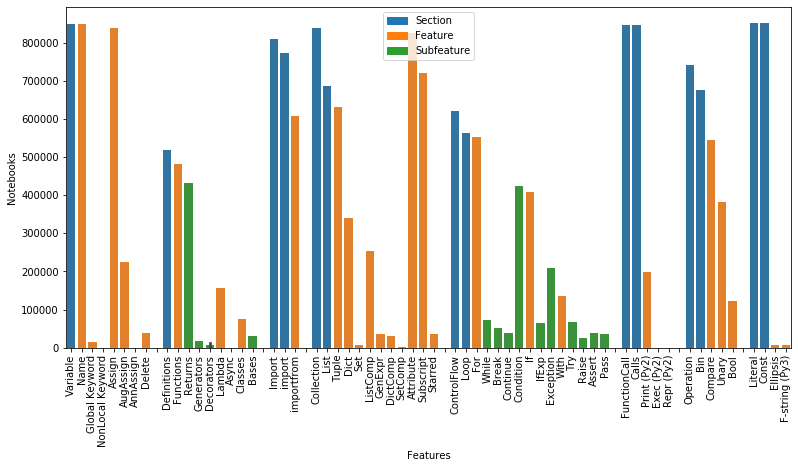

In [14]:
elements = [x for x in full_histogram]# if x[1].count(">") < 2]
index = sns.color_palette(n_colors=3)
colors = [
    index[x[1].count(">")] for x in elements
]

df2 = pd.DataFrame(elements, columns=["Features", "Type", "Quantity"])
ax = sns.barplot(x="Features", y="Quantity", data=df2,  palette=colors)
fig = ax.get_figure()
fig.set_size_inches(13, 11)
plt.xticks(rotation=90)
legend_patches = [
    matplotlib.patches.Patch(color=index[0], label='Section'),
    matplotlib.patches.Patch(color=index[1], label='Feature'),
    matplotlib.patches.Patch(color=index[2], label='Subfeature'),
]
ax.set(ylabel='Notebooks')
plt.legend(handles=legend_patches)
plt.gcf().subplots_adjust(bottom=0.45)


In [15]:
hist = pd.DataFrame(elements, columns=["Element", "Type", "Quantity"])
hist["Percentage"] = hist["Quantity"] / total_notebooks

## Variable Assignments

### AST Nodes

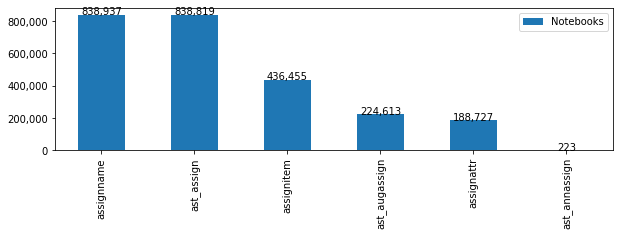

,Notebooks
assignname,838937
ast_assign,838819
assignitem,436455
ast_augassign,224613
assignattr,188727
ast_annassign,223


In [16]:
counter_hist(
    count(
        notebooks,
        "ast_assign",
        "ast_augassign",
        "ast_annassign",   
        "assignname",
        "assignattr",
        "assignitem",

    ), 
    label="Notebooks",
    width=10,
    show_values=True,
    template="{:,}",
    template2="{:,.0f}",
    logy=False
)

### Inference

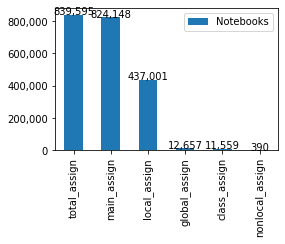

,Notebooks
total_assign,839595
main_assign,824148
local_assign,437001
global_assign,12657
class_assign,11559
nonlocal_assign,390


In [17]:
show_scope(notebooks, "assign")

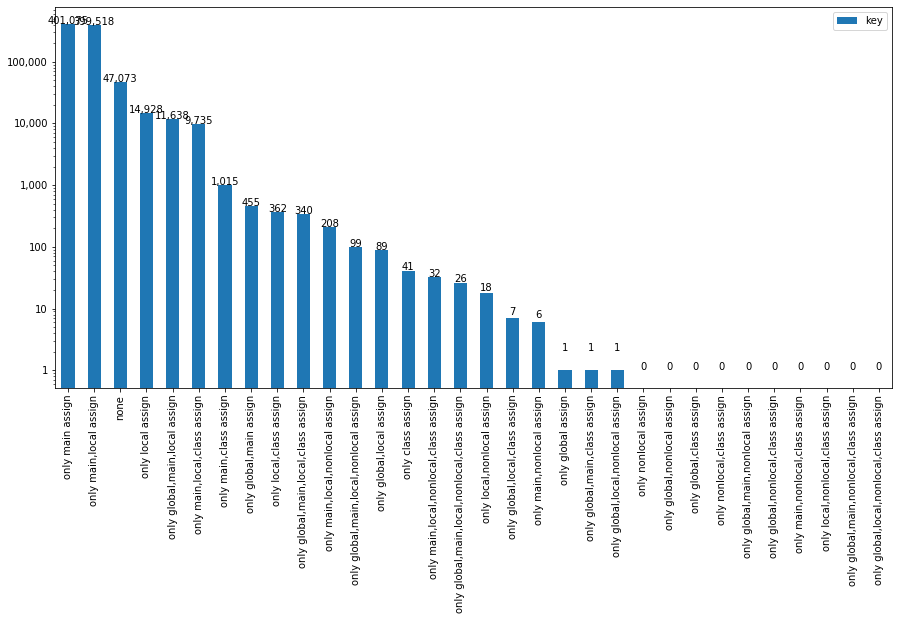

,key
only main assign,401075
"only main,local assign",399518
none,47073
only local assign,14928
"only global,main,local assign",11638
"only main,local,class assign",9735
"only main,class assign",1015
"only global,main assign",455
"only local,class assign",362
"only global,main,local,class assign",340


In [18]:
describe_sets(notebooks, "assign")

## Deletes

### AST Nodes

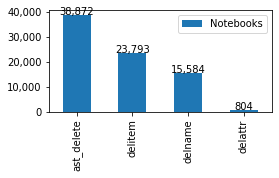

,Notebooks
ast_delete,38872
delitem,23793
delname,15584
delattr,804


In [19]:
counter_hist(count(
    notebooks,
    "delname",
    "delattr",
    "delitem",
    "ast_delete",
), 
    label="Notebooks",
    width=4,
    show_values=True,
    template="{:,}",
    template2="{:,.0f}",
    logy=False
)

### Inference

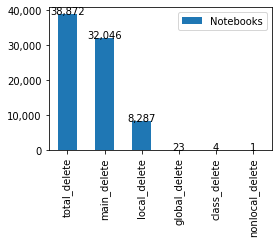

,Notebooks
total_delete,38872
main_delete,32046
local_delete,8287
global_delete,23
class_delete,4
nonlocal_delete,1


In [20]:
show_scope(notebooks, "delete")

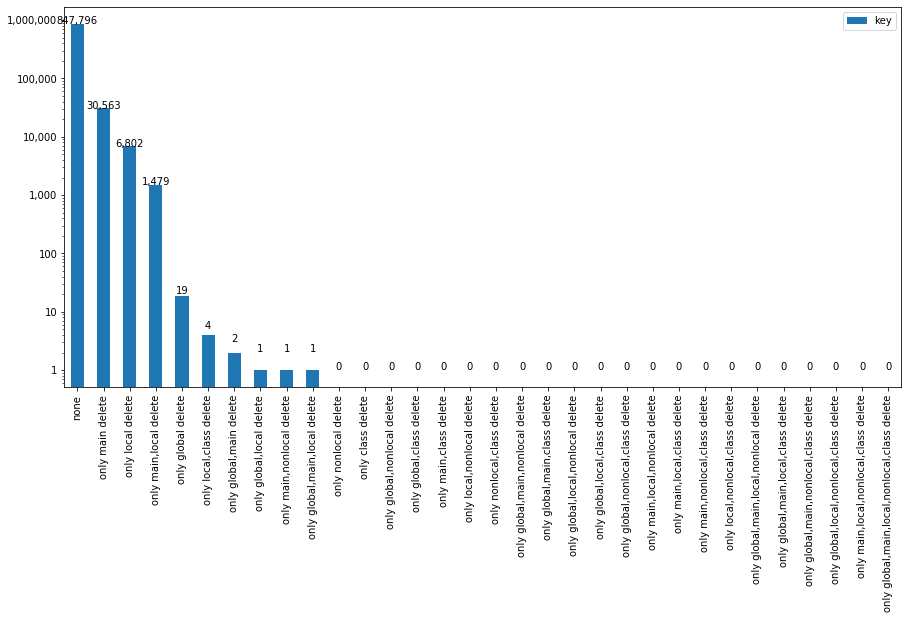

,key
none,847796
only main delete,30563
only local delete,6802
"only main,local delete",1479
only global delete,19
"only local,class delete",4
"only global,main delete",2
"only global,local delete",1
"only main,nonlocal delete",1
"only global,main,local delete",1


In [21]:
describe_sets(notebooks, "delete")

## Functions

### AST Nodes

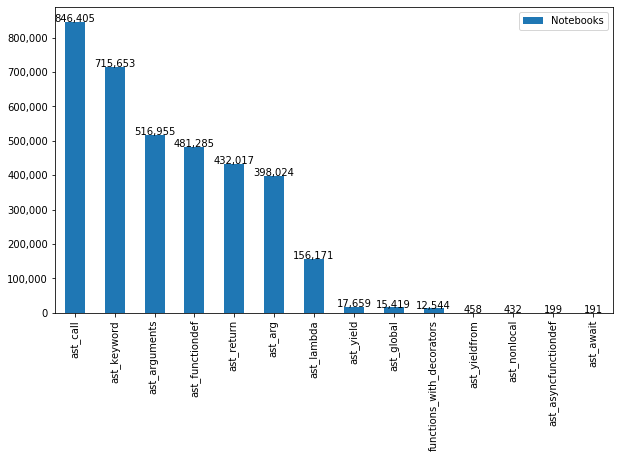

,Notebooks
ast_call,846405
ast_keyword,715653
ast_arguments,516955
ast_functiondef,481285
ast_return,432017
ast_arg,398024
ast_lambda,156171
ast_yield,17659
ast_global,15419
functions_with_decorators,12544


In [22]:
counter_hist(
    count(
        notebooks,
        "functions_with_decorators",
        "ast_functiondef",
        "ast_asyncfunctiondef",
        "ast_arguments",
        "ast_global",
        "ast_nonlocal",
        "ast_arg",
        "ast_keyword",
        "ast_return",
        "ast_yield",
        "ast_yieldfrom",
        "ast_await",
        "ast_lambda",
        "ast_call",
    ),
    label="Notebooks",
    width=10,
    show_values=True,
    logy=False,
    template="{:,}",
    template2="{:,.0f}",
)

### Inference

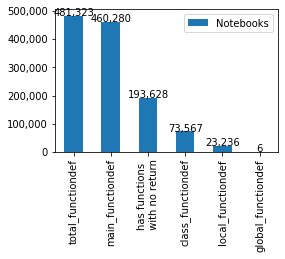

,Notebooks
total_functiondef,481323
main_functiondef,460280
has functions\n with no return,193628
class_functiondef,73567
local_functiondef,23236
global_functiondef,6


In [23]:
show_scope(notebooks, "functiondef", Counter({
    "has functions\n with no return": len(notebooks[
        (notebooks["ast_return"] < notebooks["ast_functiondef"])
        & (notebooks["ast_yield"] == 0)
        & (notebooks["ast_yieldfrom"] == 0)
    ]),
}))

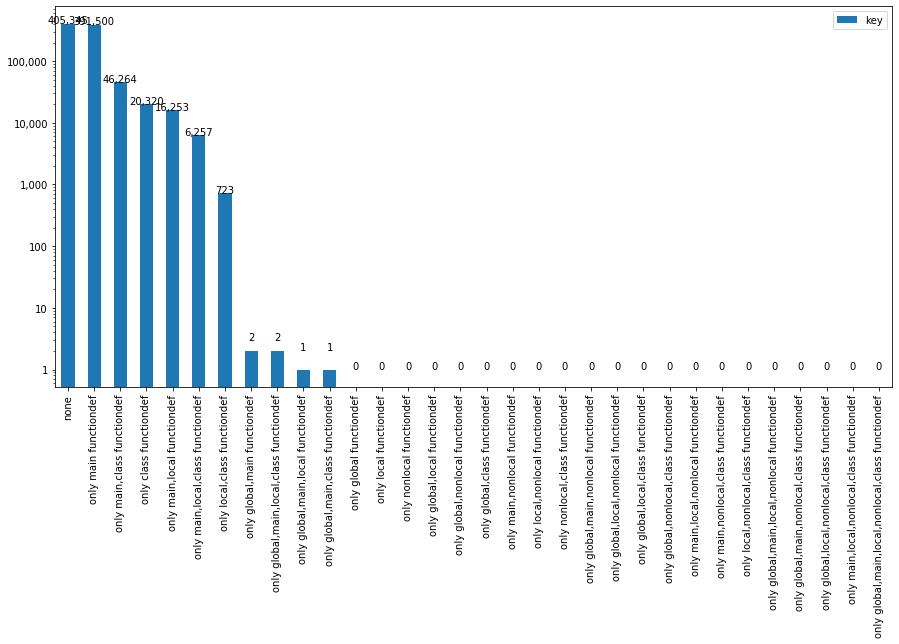

,key
none,405345
only main functiondef,391500
"only main,class functiondef",46264
only class functiondef,20320
"only main,local functiondef",16253
"only main,local,class functiondef",6257
"only local,class functiondef",723
"only global,main functiondef",2
"only global,main,local,class functiondef",2
"only global,main,local functiondef",1


In [24]:
describe_sets(notebooks, "functiondef")

## Classes

### AST Nodes

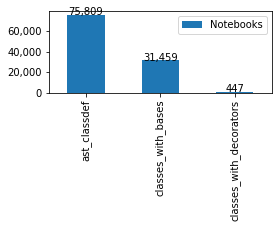

,Notebooks
ast_classdef,75809
classes_with_bases,31459
classes_with_decorators,447


In [25]:
counter_hist(
    count(
        notebooks,
        "classes_with_decorators",
        "classes_with_bases",
        "ast_classdef",
    ),
    label="Notebooks",
    width=4,
    show_values=True,
    logy=False,
    template="{:,}",
    template2="{:,.0f}",
)

### Inference

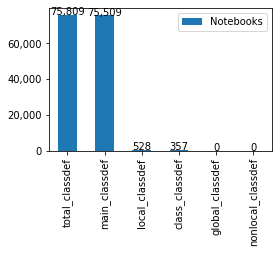

,Notebooks
total_classdef,75809
main_classdef,75509
local_classdef,528
class_classdef,357
global_classdef,0
nonlocal_classdef,0


In [26]:
show_scope(notebooks, "classdef")

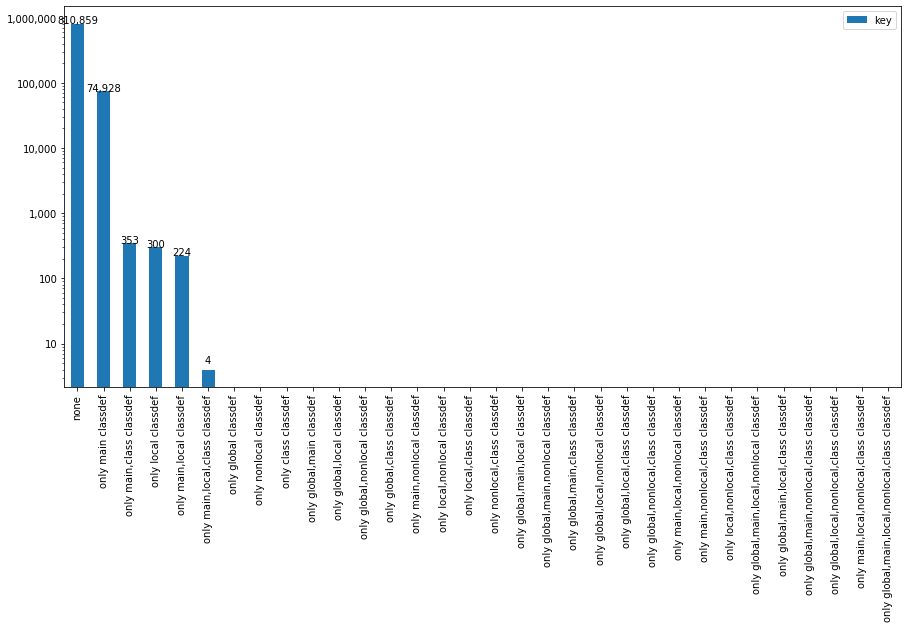

,key
none,810859
only main classdef,74928
"only main,class classdef",353
only local classdef,300
"only main,local classdef",224
"only main,local,class classdef",4
only global classdef,0
only nonlocal classdef,0
only class classdef,0
"only global,main classdef",0


In [27]:
describe_sets(notebooks, "classdef")

## Imports

### AST Nodes

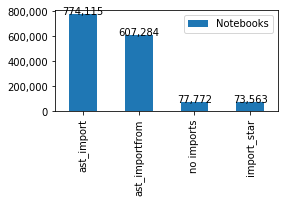

,Notebooks
ast_import,774115
ast_importfrom,607284
no imports,77772
import_star,73563


In [28]:
counter_hist(count(
    notebooks,
    "ast_importfrom",
    "ast_import",
    "import_star",
) + Counter({
    "no imports": len(notebooks[(notebooks["ast_import"] == 0) & (notebooks["ast_importfrom"] == 0)]),
}), 
    label="Notebooks",
    width=4,
    show_values=True,
    template="{:,}",
    template2="{:,.0f}",
    logy=False
)

### Inference

#### nonlocal imports

In [29]:
len(notebooks[
    (notebooks["nonlocal_importfrom"] != 0)
    | (notebooks["nonlocal_import"] != 0)
])

0

#### class imports

In [30]:
len(notebooks[
    (notebooks["nonlocal_importfrom"] != 0)
    | (notebooks["nonlocal_import"] != 0)
])

0

#### global keyword imports

Imports inside functions that use the global keyword

In [31]:
len(notebooks[
    (notebooks["global_importfrom"] != 0)
    | (notebooks["global_import"] != 0)
])

16

#### ImportFrom and Import

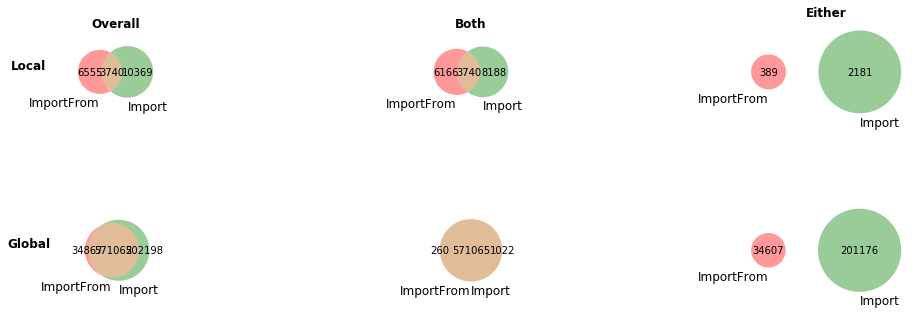

In [32]:
both = notebooks[
    (notebooks["total_importfrom"] != 0) &
    (notebooks["total_import"] != 0)
]
either = notebooks[
    (
        (notebooks["total_importfrom"] != 0) |
        (notebooks["total_import"] != 0)
    ) &
    (~ (
        (notebooks["total_importfrom"] != 0) &
        (notebooks["total_import"] != 0)
    ))
]
imports = notebooks[
    (notebooks["total_importfrom"] != 0) |
    (notebooks["total_import"] != 0)
]

def venn_diagram(n, mode, ax=None):
    sizes = (
        len(n[(n[mode + "_importfrom"] != 0) & (n[mode + "_import"] == 0)]),
        len(n[(n[mode + "_importfrom"] == 0) & (n[mode + "_import"] != 0)]),
        len(n[(n[mode + "_importfrom"] != 0) & (n[mode + "_import"] != 0)]),
    )
    return venn2(subsets=sizes, set_labels=('ImportFrom', 'Import'), ax=ax)



f, axes = plt.subplots(2, 3)
((a0, ax1, ax2), (a1, ax3, ax4)) = axes

venn_diagram(imports, "local", ax=a0)
venn_diagram(both, "local", ax=ax1)
venn_diagram(either, "local", ax=ax2)
venn_diagram(imports, "main", ax=a1)
venn_diagram(both, "main", ax=ax3)
venn_diagram(either, "main", ax=ax4)


a0.set_title("Overall", fontweight='bold')
ax1.set_title("Both", fontweight='bold')
ax1.set_ylabel("local", rotation=0, size="large")
ax2.set_title("Either", fontweight='bold')

for ax, row in zip(axes[:,0], ["Local", "Global"]):
    ax.patch.set_facecolor('white')
    ax.set_ylabel(row, rotation=0, size="large", fontweight='bold')
    ax.set_axis_on()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.set_xlim([-1.5, 1.5])
    ax.set_ylim([-0.7, 0.7])

for ax in axes[:, 1]:
    #ax.set_axis_on()
    ax.set_xlim([-1.5, 1.5])
    ax.set_ylim([-0.7, 0.7])
f.tight_layout(pad=2)
f.set_size_inches(15, 6)
plt.show()



### Scopes

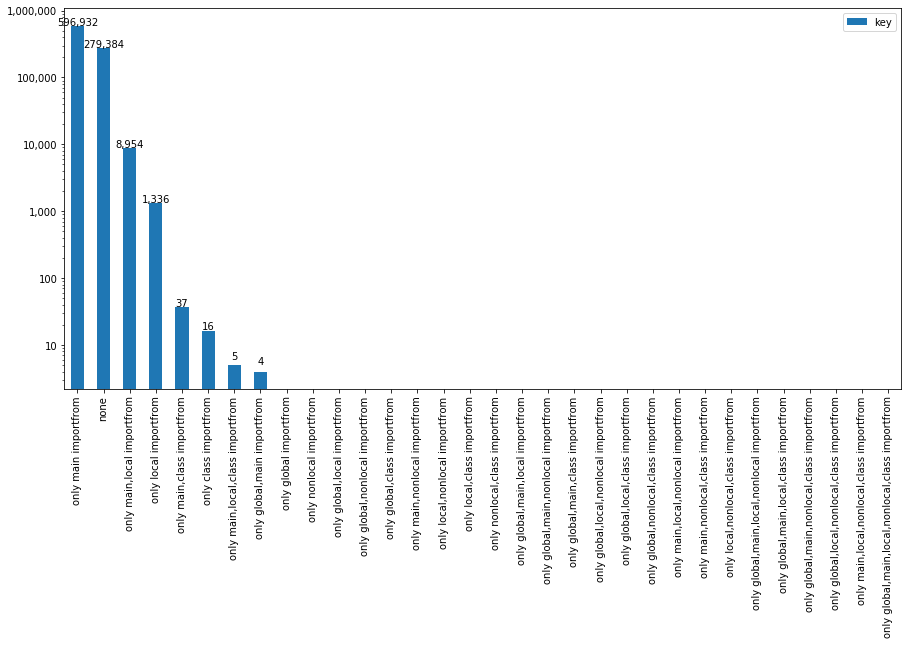

,key
only main importfrom,596932
none,279384
"only main,local importfrom",8954
only local importfrom,1336
"only main,class importfrom",37
only class importfrom,16
"only main,local,class importfrom",5
"only global,main importfrom",4
only global importfrom,0
only nonlocal importfrom,0


In [33]:
describe_sets(notebooks, "importfrom")

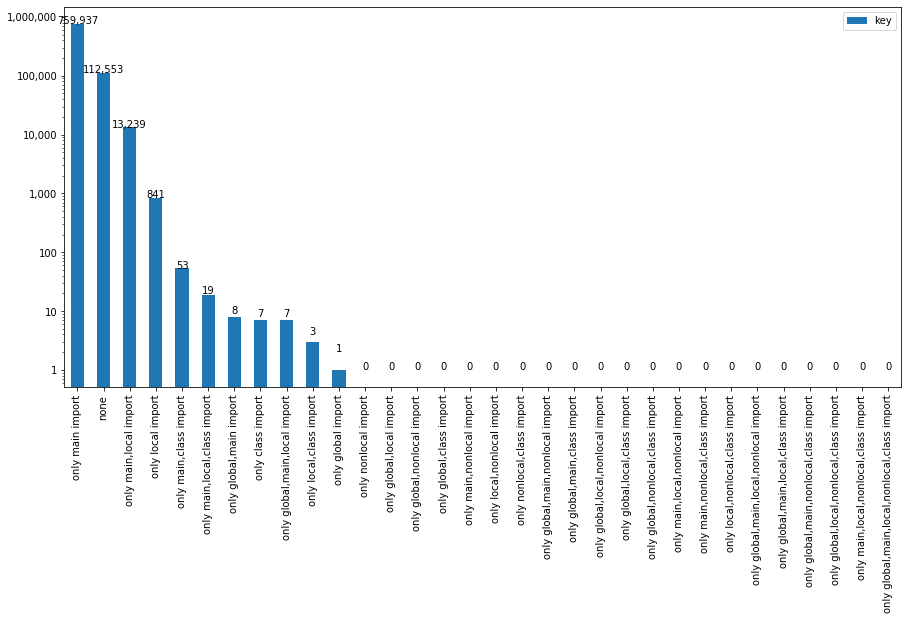

,key
only main import,759937
none,112553
"only main,local import",13239
only local import,841
"only main,class import",53
"only main,local,class import",19
"only global,main import",8
only class import,7
"only global,main,local import",7
"only local,class import",3


In [34]:
describe_sets(notebooks, "import")

## Collections / Objects

### AST Nodes

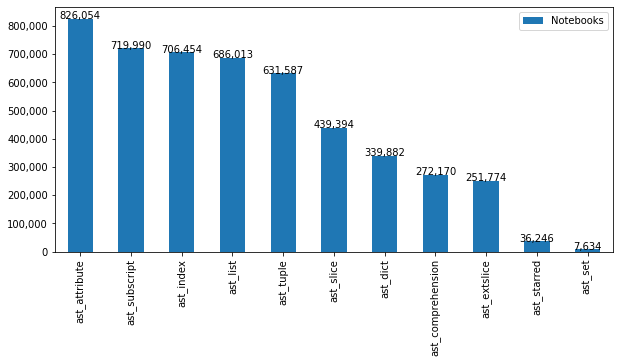

,Notebooks
ast_attribute,826054
ast_subscript,719990
ast_index,706454
ast_list,686013
ast_tuple,631587
ast_slice,439394
ast_dict,339882
ast_comprehension,272170
ast_extslice,251774
ast_starred,36246


In [35]:
counter_hist(count(
    notebooks,
    "ast_list",
    "ast_dict",
    "ast_set",
    "ast_tuple",
    "ast_index",
    "ast_subscript",
    "ast_attribute",
    "ast_starred",
    "ast_slice",
    "ast_extslice",
    "ast_comprehension",
), 
    label="Notebooks",
    width=10,
    show_values=True,
    template="{:,}",
    template2="{:,.0f}",
    logy=False
)

### Comprehension

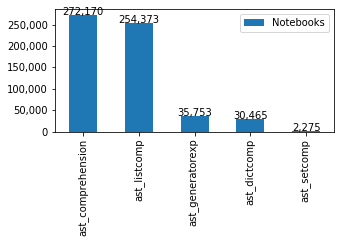

,Notebooks
ast_comprehension,272170
ast_listcomp,254373
ast_generatorexp,35753
ast_dictcomp,30465
ast_setcomp,2275


In [36]:
counter_hist(count(
    notebooks,
    "ast_listcomp",
    "ast_dictcomp",
    "ast_setcomp",
    "ast_generatorexp",
    "ast_comprehension",
), 
    label="Notebooks",
    width=5,
    show_values=True,
    template="{:,}",
    template2="{:,.0f}",
    logy=False
)

General


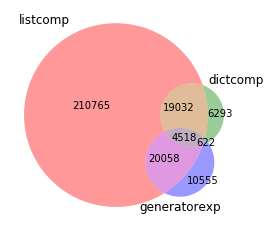

In [37]:
print("General")
venn3(
    [
        len(notebooks[(notebooks["ast_listcomp"] != 0) & (notebooks["ast_dictcomp"] == 0) & (notebooks["ast_generatorexp"] == 0)]),
        len(notebooks[(notebooks["ast_listcomp"] == 0) & (notebooks["ast_dictcomp"] != 0) & (notebooks["ast_generatorexp"] == 0)]),
        len(notebooks[(notebooks["ast_listcomp"] != 0) & (notebooks["ast_dictcomp"] != 0) & (notebooks["ast_generatorexp"] == 0)]),
        len(notebooks[(notebooks["ast_listcomp"] == 0) & (notebooks["ast_dictcomp"] == 0) & (notebooks["ast_generatorexp"] != 0)]),
        len(notebooks[(notebooks["ast_listcomp"] != 0) & (notebooks["ast_dictcomp"] == 0) & (notebooks["ast_generatorexp"] != 0)]),
        len(notebooks[(notebooks["ast_listcomp"] == 0) & (notebooks["ast_dictcomp"] != 0) & (notebooks["ast_generatorexp"] != 0)]),
        len(notebooks[(notebooks["ast_listcomp"] != 0) & (notebooks["ast_dictcomp"] != 0) & (notebooks["ast_generatorexp"] != 0)]),
    ],
    ["listcomp", "dictcomp", "generatorexp"]
);

With set comprehension


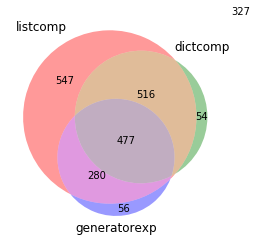

In [38]:
print("With set comprehension")
with_setcomp = notebooks[notebooks["ast_setcomp"] != 0]
fig = plt.figure()
ax = fig.add_subplot(111)
venn3(
    [
        len(with_setcomp[(with_setcomp["ast_listcomp"] != 0) & (with_setcomp["ast_dictcomp"] == 0) & (with_setcomp["ast_generatorexp"] == 0)]),
        len(with_setcomp[(with_setcomp["ast_listcomp"] == 0) & (with_setcomp["ast_dictcomp"] != 0) & (with_setcomp["ast_generatorexp"] == 0)]),
        len(with_setcomp[(with_setcomp["ast_listcomp"] != 0) & (with_setcomp["ast_dictcomp"] != 0) & (with_setcomp["ast_generatorexp"] == 0)]),
        len(with_setcomp[(with_setcomp["ast_listcomp"] == 0) & (with_setcomp["ast_dictcomp"] == 0) & (with_setcomp["ast_generatorexp"] != 0)]),
        len(with_setcomp[(with_setcomp["ast_listcomp"] != 0) & (with_setcomp["ast_dictcomp"] == 0) & (with_setcomp["ast_generatorexp"] != 0)]),
        len(with_setcomp[(with_setcomp["ast_listcomp"] == 0) & (with_setcomp["ast_dictcomp"] != 0) & (with_setcomp["ast_generatorexp"] != 0)]),
        len(with_setcomp[(with_setcomp["ast_listcomp"] != 0) & (with_setcomp["ast_dictcomp"] != 0) & (with_setcomp["ast_generatorexp"] != 0)]),
    ],
    ["listcomp", "dictcomp", "generatorexp"],
    ax=ax
)
ax.text(0.7, 0.7, str(len(with_setcomp[(with_setcomp["ast_listcomp"] == 0) & (with_setcomp["ast_dictcomp"] == 0) & (with_setcomp["ast_generatorexp"] == 0)]),))
plt.plot();

## Control Flow

### Exceptions

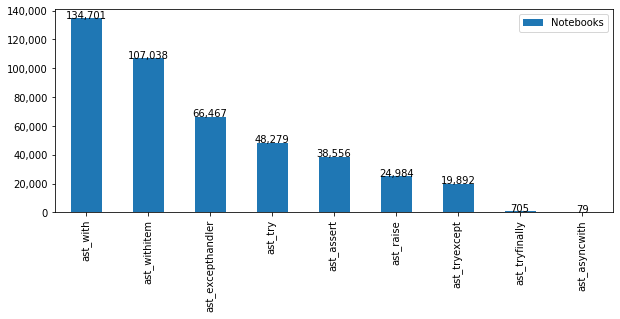

,Notebooks
ast_with,134701
ast_withitem,107038
ast_excepthandler,66467
ast_try,48279
ast_assert,38556
ast_raise,24984
ast_tryexcept,19892
ast_tryfinally,705
ast_asyncwith,79


In [39]:
counter_hist(count(
    notebooks,
    "ast_raise",
    "ast_excepthandler",
    "ast_assert",
    "ast_tryexcept",
    "ast_tryfinally",
    "ast_try",
    "ast_with",
    "ast_asyncwith",
    "ast_withitem",
), 
    label="Notebooks",
    width=10,
    show_values=True,
    template="{:,}",
    template2="{:,.0f}",
    logy=False
)

### Loops and conditions

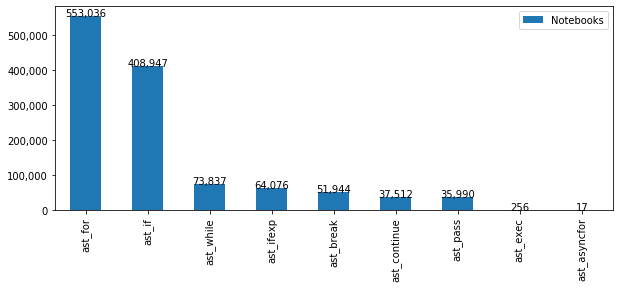

,Notebooks
ast_for,553036
ast_if,408947
ast_while,73837
ast_ifexp,64076
ast_break,51944
ast_continue,37512
ast_pass,35990
ast_exec,256
ast_asyncfor,17


In [40]:
counter_hist(count(
    notebooks,
    "ast_break",
    "ast_continue",
    "ast_exec",
    "ast_for",
    "ast_asyncfor",
    "ast_if",
    "ast_ifexp",
    "ast_pass",
    "ast_while",
), 
    label="Notebooks",
    width=10,
    show_values=True,
    template="{:,}",
    template2="{:,.0f}",
    logy=False
)

## Async

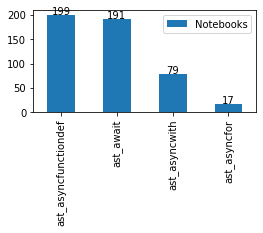

,Notebooks
ast_asyncfunctiondef,199
ast_await,191
ast_asyncwith,79
ast_asyncfor,17


In [41]:
counter_hist(count(
    notebooks,
    "ast_asyncwith",
    "ast_asyncfor",
    "ast_await",
    "ast_asyncfunctiondef",
), 
    label="Notebooks",
    width=4,
    show_values=True,
    template="{:,}",
    template2="{:,.0f}",
    logy=False
)

## Operations

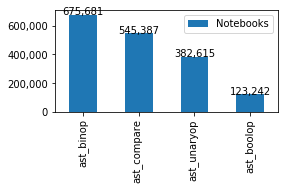

,Notebooks
ast_binop,675681
ast_compare,545387
ast_unaryop,382615
ast_boolop,123242


In [42]:
counter_hist(count(
    notebooks,
    "ast_boolop",
    "ast_binop",
    "ast_unaryop",
    "ast_compare",
), 
    label="Notebooks",
    width=4,
    show_values=True,
    template="{:,}",
    template2="{:,.0f}",
    logy=False
)

### boolop

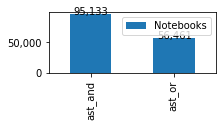

,Notebooks
ast_and,95133
ast_or,56461


In [43]:
counter_hist(count(
    notebooks,
    "ast_and",
    "ast_or",
), 
    label="Notebooks",
    width=3,
    show_values=True,
    template="{:,}",
    template2="{:,.0f}",
    logy=False
)

### binop

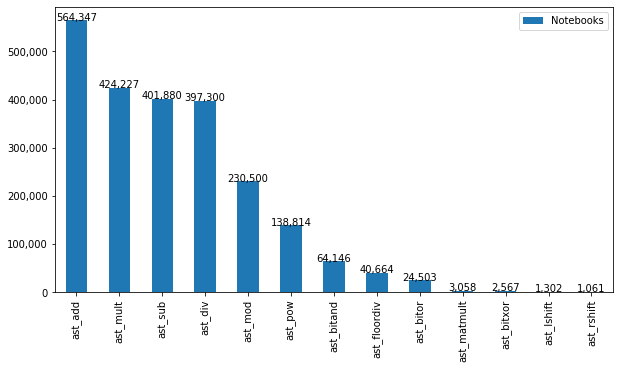

,Notebooks
ast_add,564347
ast_mult,424227
ast_sub,401880
ast_div,397300
ast_mod,230500
ast_pow,138814
ast_bitand,64146
ast_floordiv,40664
ast_bitor,24503
ast_matmult,3058


In [44]:
counter_hist(count(
    notebooks,
    "ast_add",
    "ast_sub",
    "ast_mult",
    "ast_matmult",
    "ast_div",
    "ast_mod",
    "ast_pow",
    "ast_lshift",
    "ast_rshift",
    "ast_bitor",
    "ast_bitxor",
    "ast_bitand",
    "ast_floordiv",
), 
    label="Notebooks",
    width=10,
    show_values=True,
    template="{:,}",
    template2="{:,.0f}",
    logy=False
)

### unaryop

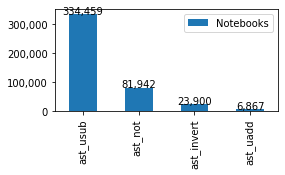

,Notebooks
ast_usub,334459
ast_not,81942
ast_invert,23900
ast_uadd,6867


In [45]:
counter_hist(count(
    notebooks,
    "ast_invert",
    "ast_not",
    "ast_uadd",
    "ast_usub",
), 
    label="Notebooks",
    width=4,
    show_values=True,
    template="{:,}",
    template2="{:,.0f}",
    logy=False
)

### cmpop

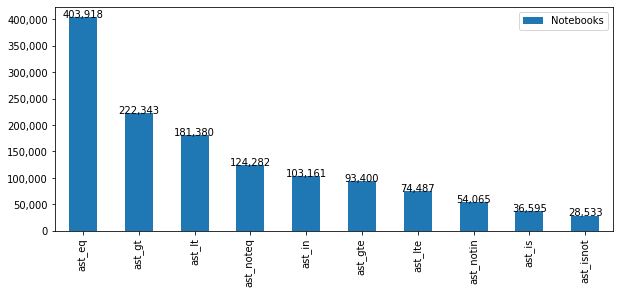

,Notebooks
ast_eq,403918
ast_gt,222343
ast_lt,181380
ast_noteq,124282
ast_in,103161
ast_gte,93400
ast_lte,74487
ast_notin,54065
ast_is,36595
ast_isnot,28533


In [46]:
counter_hist(count(
    notebooks,
    "ast_eq",
    "ast_noteq",
    "ast_lt",
    "ast_lte",
    "ast_gt",
    "ast_gte",
    "ast_is",
    "ast_isnot",
    "ast_in",
    "ast_notin",
), 
    label="Notebooks",
    width=10,
    show_values=True,
    template="{:,}",
    template2="{:,.0f}",
    logy=False
)

## Mod

We process everything as module

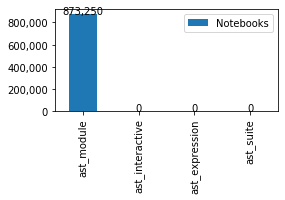

,Notebooks
ast_module,873250
ast_interactive,0
ast_expression,0
ast_suite,0


In [47]:
counter_hist(count(
    notebooks,
    "ast_module",
    "ast_interactive",
    "ast_expression",
    "ast_suite",
), 
    label="Notebooks",
    width=4,
    show_values=True,
    template="{:,}",
    template2="{:,.0f}",
    logy=False
)

## Python 2

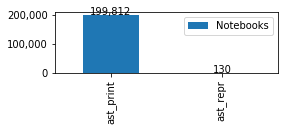

,Notebooks
ast_print,199812
ast_repr,130


In [48]:
counter_hist(count(
    notebooks,
    "ast_print",
    "ast_repr",
), 
    label="Notebooks",
    width=4,
    show_values=True,
    template="{:,}",
    template2="{:,.0f}",
    logy=False
)

## Python 3

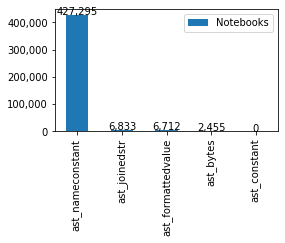

,Notebooks
ast_nameconstant,427295
ast_joinedstr,6833
ast_formattedvalue,6712
ast_bytes,2455
ast_constant,0


In [49]:
counter_hist(count(
    notebooks,
    "ast_formattedvalue",
    "ast_joinedstr",
    "ast_bytes",
    "ast_nameconstant",
    "ast_constant",
), 
    label="Notebooks",
    width=4,
    show_values=True,
    template="{:,}",
    template2="{:,.0f}",
    logy=False
)

## Expr Context

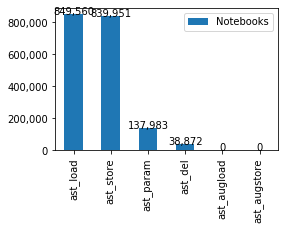

,Notebooks
ast_load,849560
ast_store,839951
ast_param,137983
ast_del,38872
ast_augload,0
ast_augstore,0


In [50]:
counter_hist(count(
    notebooks,
    "ast_load",
    "ast_store",
    "ast_del",
    "ast_augload",
    "ast_augstore",
    "ast_param",
), 
    label="Notebooks",
    width=4,
    show_values=True,
    template="{:,}",
    template2="{:,.0f}",
    logy=False
)

## Others

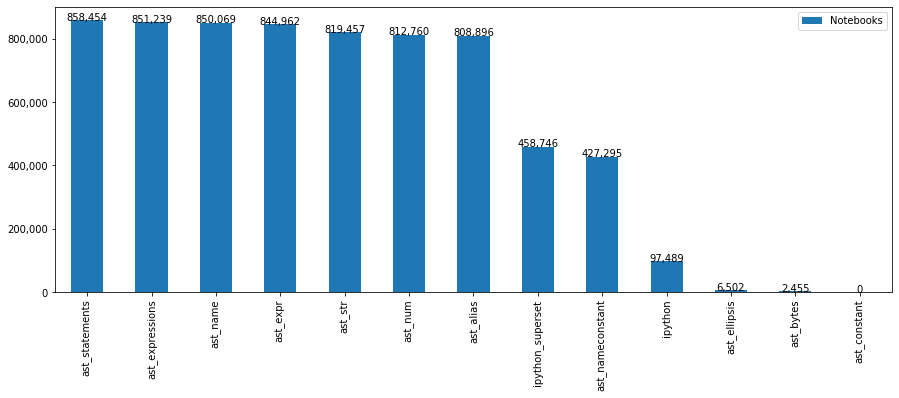

,Notebooks
ast_statements,858454
ast_expressions,851239
ast_name,850069
ast_expr,844962
ast_str,819457
ast_num,812760
ast_alias,808896
ipython_superset,458746
ast_nameconstant,427295
ipython,97489


In [51]:
counter_hist(count(
    notebooks,
    # our
    "ipython",
    "ipython_superset",
    "ast_statements",
    "ast_expressions",
    # ast
    "ast_expr",
    "ast_ellipsis",
    "ast_name",
    "ast_constant",
    "ast_num",
    "ast_str",
    "ast_bytes",
    "ast_nameconstant",
    "ast_alias",
), 
    label="Notebooks",
    width=15,
    show_values=True,
    template="{:,}",
    template2="{:,.0f}",
    logy=False
)

In [52]:
notebooks[notebooks["ast_others"] != ""]

,id,repository_id,notebook_id,cell_count,import_star,functions_with_decorators,classes_with_decorators,classes_with_bases,delname,delattr,...,ast_others,skip,ast_extslice,ast_repr,main_importfrom,main_import,main_assign,main_delete,main_functiondef,main_classdef


Other AST analyses are available at A3.RQ3.RQ4